In [1]:
# import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns

# import linregress method from scipy module
from scipy.stats import linregress

In [2]:
# create variable to reference csv file to read to notebook
data = "Resources/cleaned_used_car_data.csv"

In [3]:
# read csv file into Pandas DataFrame
df_raw = pd.read_csv(data)

In [4]:
# preview DataFrame
df_raw.head()

,Unnamed: 0,ID,pricesold,yearsold,zipcode,Mileage,Make,Model,Year,Trim,Engine,BodyType,NumCylinders,DriveType
0,2,119660,8750,2020,33449,55000,Jaguar,XJS,1995,2+2 Cabriolet,4.0L In-Line 6 Cylinder,Convertible,6,RWD
1,3,80773,11600,2019,7852,97200,Ford,Mustang,1968,Stock,289 cu. in. V8,Coupe,8,RWD
2,4,64287,44000,2019,7728,40703,Porsche,911,2002,Turbo X-50,3.6L,Coupe,6,AWD
3,7,5250,70000,2019,7627,6500,Land Rover,Defender,1997,NaN,4.0 Liter Fuel Injected V8,NaN,0,4WD
4,8,29023,1330,2019,7043,167000,Honda,Civic,2001,EX,NaN,Coupe,4,FWD


In [5]:
# create copy of DataFrame with columns selected columns
df_analysis = df_raw[["ID", "pricesold", "yearsold", "zipcode", "Mileage", "Make", "Model", "Year","NumCylinders", "Trim"]]

In [6]:
# filter DataFrame for years that are not realisitic -- save to separate DataFrame
df_yr_exclude = pd.DataFrame(df_analysis.loc[(df_analysis["Year"] < 1950),:])
# df_yr_exclude.head()

In [7]:
# filter DataFrame where mileage is 0 -- save to separate DataFrame
df_0_miles = pd.DataFrame(df_analysis.loc[(df_analysis["Mileage"] == 0),:]) 
# df_0_miles

In [8]:
# create DataFrame that excludes cars with non-sense years or 0 miles
df_analysis_filtered = pd.DataFrame(df_analysis.loc[(df_analysis["Year"] >= 1950) & (df_analysis["Mileage"] != 0),])
# df_analysis_filtered

In [9]:
# copy df_analysis_filtered in order to work on CarAge calculation, transformations
df_update_age = df_analysis_filtered.copy()

In [10]:
# calculate age of the car (yearsold - year) & store in variable "CarAge"
CarAge = df_update_age["yearsold"] - df_update_age["Year"]

# add new column to DataFrame -- yearsold - Year
df_update_age["CarAge"] = CarAge

In [11]:
df_ages_to_fix = pd.DataFrame(df_update_age.loc[(df_update_age["CarAge"] < 0),:])
# df_ages_to_fix

In [12]:
# for all cars that have CarAge = -1, replace with 0. Note best practice would be to create separate dataframe using .loc and replace all vs. 1 by 1
df_update_age.at[2103,"CarAge"] = 0
df_update_age.at[3025,"CarAge"] = 0
df_update_age.at[10691,"CarAge"] = 0
df_update_age.at[10692,"CarAge"] = 0
df_update_age.at[10693,"CarAge"] = 0
df_update_age.at[17527,"CarAge"] = 0
df_update_age.at[23467,"CarAge"] = 0
df_update_age.at[25021,"CarAge"] = 0
df_update_age.at[25241,"CarAge"] = 0
df_update_age.at[29362,"CarAge"] = 0
df_update_age.at[41331,"CarAge"] = 0
df_update_age.at[47327,"CarAge"] = 0
df_update_age.at[56819,"CarAge"] = 0

#update Year for 2914 to 2014
df_update_age.at[56622,"CarAge"]=5

In [13]:
# create new series with original CarAge
OriginalCarAge = df_update_age["yearsold"] - df_update_age["Year"]

# add new column to DataFrame -- yearsold - Year
df_update_age["OriginalCarAge"] = OriginalCarAge 

In [14]:
# add revised car age to df_analysis_filtered
df_analysis_filtered["CarAge"] = df_update_age["CarAge"]
df_analysis_filtered["OriginalCarAge"] = df_update_age["OriginalCarAge"]

In [15]:
df_analysis_filtered["Model"].fillna("NaN", inplace = True)

In [16]:
# Add Make-Model to DF (would ultimately be nested for loop..)
make_model = df_analysis_filtered["Make"] + " - " + df_analysis_filtered["Model"]
df_analysis_filtered["Make-Model"] = make_model

In [17]:
# create summary for make, model metrics
avg_price_mm = df_analysis_filtered.groupby(["Make-Model"]).mean()["pricesold"]
avg_mileage_mm = df_analysis_filtered.groupby(["Make-Model"]).mean()["Mileage"]
avg_age_mm = df_analysis_filtered.groupby(["Make-Model"]).mean()["CarAge"]
number_mm = df_analysis_filtered.groupby(["Make-Model"]).count()["ID"]

# create dataframe for make, model aggregation
df_mm = pd.DataFrame({"# of Cars": number_mm, "Avg price": avg_price_mm, 
                      "Avg miles": avg_mileage_mm, "Avg age": avg_age_mm})

In [18]:
# Join data sets (filtered data is driving table; Left join on make/model aggregation)
df_group_filter = pd.merge(df_analysis_filtered, df_mm, how = "left", on=["Make-Model"])

#remove unnecessary columns
df_group_filter.drop(["Avg price", "Avg miles", "Avg age"], axis = 1, inplace = True)

# remove records where make-model of car is < 20 instances (creates noise in model, not relavent)
df_group_filter.drop(df_group_filter[df_group_filter['# of Cars'] < 25 ].index, inplace = True)

In [19]:
# drop records where Original Car Age was <0 (all rows from df_update_age, are excluded)
df_analysis_final = pd.DataFrame(df_group_filter.loc[(df_group_filter["OriginalCarAge"] >= 0),:])

## For-Loop Prep - Lists and Function definitions

In [20]:
# create distinct list of car make
car_makes = sorted(list(df_analysis_final["Make"].unique()))

In [21]:
def make_model_list(make):
    df_makemodel = df_analysis_final.loc[df_analysis_final["Make"] == make]
    df_makemodel = sorted(list(df_makemodel["Make-Model"].astype(str).unique()))
    return df_makemodel

# Linear Regression - Analyzing impact of mileage & car age on price

In [22]:
# Define Lin Regression Function for Total DataFrame
def lin_regress_total(x, y, x_label, y_label, label_regression): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values
    regress_values = x * slope + intercept
    
  # create string to display regression equation
    line_eq =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    plt.figure(figsize = (10,5))

  # define labels using year_sold
    year_sold = ['2018', '2019', '2020']
    
  # generate scatterplot
    scatter = plt.scatter(x, y, c=df_analysis_final.yearsold.astype('category'), marker = 'o')
  
  # add legend to graph
    plt.legend(handles=scatter.legend_elements()[0], labels=year_sold, title = "year sold", 
               title_fontsize= 8, bbox_to_anchor = (1.17, 0.6), loc='center right', fontsize=7)
    
  # add line for linear regression
    plt.plot(x, regress_values, "r-")
    
  # add axis labels
    plt.xlabel(x_label, fontsize = 8)
    plt.ylabel(y_label, fontsize = 8) 

  # adjust tickmark labels
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    
  # add linear regression annotations
    plt.annotate(line_eq, label_regression, fontsize = 8, color = "red")

  # print r-squared value
    print(f"the r-squared value is: {rvalue**2}")
    
  # print correlation coefficient (pearson r)
    correlation = st.pearsonr(x,y)
    print(f"the correlation between factors plotted in the graph is {round(correlation[0],2)}")

the r-squared value is: 0.2021540735846835
the correlation between factors plotted in the graph is -0.45


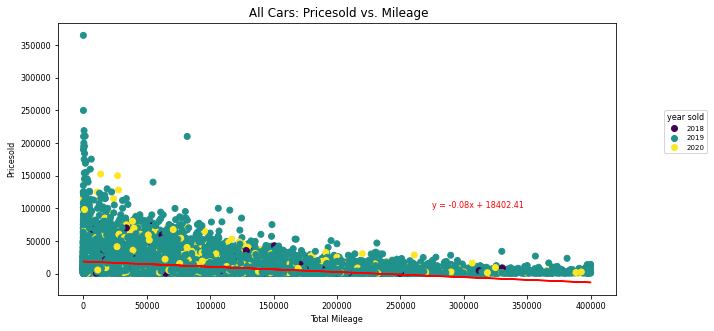

In [23]:
# Linear Regression - Price & Mileage

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_analysis_final["Mileage"]
y = df_analysis_final["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,100000)

# call function
lin_regress_total(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f" All Cars: Pricesold vs. Mileage")

# # save image
plt.savefig("Graphs-Analysis/Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.0006463891151976395
the correlation between factors plotted in the graph is -0.03


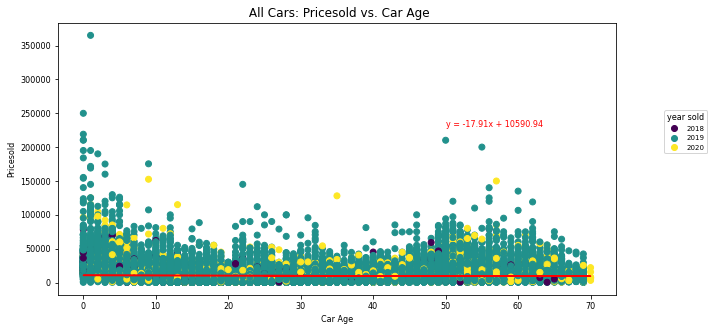

In [24]:
# Linear Regression - Price & Car Age

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_analysis_final["CarAge"]
y = df_analysis_final["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (50,230000)

# call function
lin_regress_total(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f" All Cars: Pricesold vs. Car Age")

# # save image
plt.savefig("Graphs-Analysis/Price_vs_Age.png")

# display graph
plt.show()

In [25]:
# Define functions for price/mileage, price/age linear regressions -- use for dataframe output
def make_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def make_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))
    
# create lists to store r2 and pearsonr for linear regression
miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

for make in car_makes:
    #loop through list of cars and filter where car make matches car in for loop
    df_analysis_by_make = df_analysis_final.loc[df_analysis_final["Make"] == make]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]
    
    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]
    
    x_1 = df_scatter["Mileage"]
    x_2 = df_scatter["CarAge"]
    y = df_scatter["pricesold"]

    # call functions
    make_regress_pricemiles(x_1, y)
    make_regress_priceage(x_2,y)

# zip list of variables used in regression model
results_make = zip(car_makes, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_make = list(results_make)

# create empty lists to store values from list_regression by make
reg_a = []
reg_b = []
reg_c = []
reg_d = []
reg_e = []

for make in list_regress_make:
    reg_a.append(make[0])
    reg_b.append(make[1])
    reg_c.append(make[2])
    reg_d.append(make[3])
    reg_e.append(make[4])

# create a dictionary of values from IQR zipped list
dict_lr = {"Make": reg_a, "Price/Miles - R^2": reg_b, "Price/Miles - PearsonR" : reg_c,
            "Price/Age - R^2": reg_d, "Price/Age - PearsonR": reg_e}

# create DataFrame from dictionary
df_make_regress = pd.DataFrame(dict_lr)
df_make_regress.sort_values(by = (["Price/Miles - R^2", "Price/Age - R^2"]), ascending = False, inplace = True)

In [26]:
# preview data frame 
df_make_regress

,Make,Price/Miles - R^2,Price/Miles - PearsonR,Price/Age - R^2,Price/Age - PearsonR
0,Audi,0.409511,-0.64,0.510402,-0.71
19,Subaru,0.404280,-0.64,0.338325,-0.58
9,Honda,0.402667,-0.63,0.324855,-0.57
13,Lexus,0.370253,-0.61,0.455066,-0.67
11,Jeep,0.353280,-0.59,0.188031,-0.43
5,Chrysler,0.319204,-0.56,0.021719,-0.15
20,Toyota,0.314575,-0.56,0.042049,-0.21
1,BMW,0.311513,-0.56,0.128702,-0.36
8,GMC,0.307132,-0.55,0.236249,-0.49
12,Land Rover,0.283261,-0.53,0.045181,-0.21


In [27]:
# Linear Regression by Make - Lexus
list_makemodel = make_model_list("Lexus")

miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

def model_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def model_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))

# Loop through make-model for Lexus cars, call regression function
for make in make_model_list("Lexus"):
    df_analysis_by_make = df_analysis_final.loc[(df_analysis_final["Make-Model"] == make)]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]

    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]

    x_3 = df_scatter["Mileage"]
    x_4 = df_scatter["CarAge"]
    y_1 = df_scatter["pricesold"]

    # call functions
    model_regress_pricemiles(x_3, y_1)
    model_regress_priceage(x_4,y_1)

results_model = zip(list_makemodel, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_model = list(results_model)

# create empty lists to store values from list
reg_f = []
reg_g = []
reg_h = []
reg_i = []
reg_j = []

for make in list_regress_model:
    reg_f.append(make[0])
    reg_g.append(make[1])
    reg_h.append(make[2])
    reg_i.append(make[3])
    reg_j.append(make[4])
    
# create a dictionary of values from zipped list
dict_model = {"Make-Model": reg_f, "Price/Miles - R^2": reg_g, "Price/Miles - PearsonR" : reg_h,
              "Price/Age - R^2": reg_i, "Price/Age - PearsonR": reg_j}

# create DataFrame from dictionary
df_lexus = pd.DataFrame(dict_model)

df_lexus.sort_values(by = (["Make-Model"]), ascending = False, inplace = True)
df_lexus =df_lexus.reindex(columns=["Make-Model", "Price/Miles - R^2", "Price/Miles - PearsonR",
                                        "Price/Age - R^2", "Price/Age - PearsonR" ])

In [28]:
# Linear Regression by Make - Subaru
list_makemodel = make_model_list("Subaru")

miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

def model_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def model_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))

# Loop through make-model call regression function
for make in make_model_list("Subaru"):
    df_analysis_by_make = df_analysis_final.loc[(df_analysis_final["Make-Model"] == make)]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]

    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]

    x_3 = df_scatter["Mileage"]
    x_4 = df_scatter["CarAge"]
    y_1 = df_scatter["pricesold"]

    # call functions
    model_regress_pricemiles(x_3, y_1)
    model_regress_priceage(x_4,y_1)

results_model = zip(list_makemodel, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_model = list(results_model)

# create empty lists to store values from list
reg_f = []
reg_g = []
reg_h = []
reg_i = []
reg_j = []

for make in list_regress_model:
    reg_f.append(make[0])
    reg_g.append(make[1])
    reg_h.append(make[2])
    reg_i.append(make[3])
    reg_j.append(make[4])
    
# create a dictionary of values from zipped list
dict_model = {"Make-Model": reg_f, "Price/Miles - R^2": reg_g, "Price/Miles - PearsonR" : reg_h,
              "Price/Age - R^2": reg_i, "Price/Age - PearsonR": reg_j}

# create DataFrame from dictionary
df_subaru = pd.DataFrame(dict_model)

df_subaru.sort_values(by = (["Make-Model"]), ascending = False, inplace = True)
df_subaru =df_subaru.reindex(columns=["Make-Model", "Price/Miles - R^2", "Price/Miles - PearsonR",
                                        "Price/Age - R^2", "Price/Age - PearsonR" ])

In [29]:
# Linear Regression by Make - Honda
list_makemodel = make_model_list("Honda")

miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

def model_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def model_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))

# Loop through make-model call regression function
for make in make_model_list("Honda"):
    df_analysis_by_make = df_analysis_final.loc[(df_analysis_final["Make-Model"] == make)]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]

    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]

    x_3 = df_scatter["Mileage"]
    x_4 = df_scatter["CarAge"]
    y_1 = df_scatter["pricesold"]

    # call functions
    model_regress_pricemiles(x_3, y_1)
    model_regress_priceage(x_4,y_1)

results_model = zip(list_makemodel, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_model = list(results_model)

# create empty lists to store values from list
reg_f = []
reg_g = []
reg_h = []
reg_i = []
reg_j = []

for make in list_regress_model:
    reg_f.append(make[0])
    reg_g.append(make[1])
    reg_h.append(make[2])
    reg_i.append(make[3])
    reg_j.append(make[4])
    
# create a dictionary of values from zipped list
dict_model = {"Make-Model": reg_f, "Price/Miles - R^2": reg_g, "Price/Miles - PearsonR" : reg_h,
              "Price/Age - R^2": reg_i, "Price/Age - PearsonR": reg_j}

# create DataFrame from dictionary
df_honda = pd.DataFrame(dict_model)

df_honda.sort_values(by = (["Make-Model"]), ascending = False, inplace = True)
df_honda = df_honda.reindex(columns=["Make-Model", "Price/Miles - R^2", "Price/Miles - PearsonR",
                                        "Price/Age - R^2", "Price/Age - PearsonR" ])

In [30]:
# Linear Regression by Make - Audi
list_makemodel = make_model_list("Audi")

miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

def model_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def model_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))

# Loop through make-model call regression function
for make in make_model_list("Audi"):
    df_analysis_by_make = df_analysis_final.loc[(df_analysis_final["Make-Model"] == make)]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]

    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]

    x_3 = df_scatter["Mileage"]
    x_4 = df_scatter["CarAge"]
    y_1 = df_scatter["pricesold"]

    # call functions
    model_regress_pricemiles(x_3, y_1)
    model_regress_priceage(x_4,y_1)

results_model = zip(list_makemodel, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_model = list(results_model)

# create empty lists to store values from list
reg_f = []
reg_g = []
reg_h = []
reg_i = []
reg_j = []

for make in list_regress_model:
    reg_f.append(make[0])
    reg_g.append(make[1])
    reg_h.append(make[2])
    reg_i.append(make[3])
    reg_j.append(make[4])
    
# create a dictionary of values from zipped list
dict_model = {"Make-Model": reg_f, "Price/Miles - R^2": reg_g, "Price/Miles - PearsonR" : reg_h,
              "Price/Age - R^2": reg_i, "Price/Age - PearsonR": reg_j}

# create DataFrame from dictionary
df_audi = pd.DataFrame(dict_model)

df_audi.sort_values(by = (["Make-Model"]), ascending = False, inplace = True)
df_audi = df_audi.reindex(columns=["Make-Model", "Price/Miles - R^2", "Price/Miles - PearsonR",
                                        "Price/Age - R^2", "Price/Age - PearsonR" ])

In [31]:
# Linear Regression by Make - GMC
list_makemodel = make_model_list("GMC")

miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

def model_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def model_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))

# Loop through make-model call regression function
for make in make_model_list("GMC"):
    df_analysis_by_make = df_analysis_final.loc[(df_analysis_final["Make-Model"] == make)]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]

    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]

    x_3 = df_scatter["Mileage"]
    x_4 = df_scatter["CarAge"]
    y_1 = df_scatter["pricesold"]

    # call functions
    model_regress_pricemiles(x_3, y_1)
    model_regress_priceage(x_4,y_1)

results_model = zip(list_makemodel, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_model = list(results_model)

# create empty lists to store values from list
reg_f = []
reg_g = []
reg_h = []
reg_i = []
reg_j = []

for make in list_regress_model:
    reg_f.append(make[0])
    reg_g.append(make[1])
    reg_h.append(make[2])
    reg_i.append(make[3])
    reg_j.append(make[4])
    
# create a dictionary of values from zipped list
dict_model = {"Make-Model": reg_f, "Price/Miles - R^2": reg_g, "Price/Miles - PearsonR" : reg_h,
              "Price/Age - R^2": reg_i, "Price/Age - PearsonR": reg_j}

# create DataFrame from dictionary
df_GMC = pd.DataFrame(dict_model)

df_GMC.sort_values(by = (["Make-Model"]), ascending = False, inplace = True)
df_GMC = df_GMC.reindex(columns=["Make-Model", "Price/Miles - R^2", "Price/Miles - PearsonR",
                                        "Price/Age - R^2", "Price/Age - PearsonR" ])

In [32]:
# Linear Regression by Make - Mercedes-Benz
list_makemodel = make_model_list("Mercedes-Benz")

miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

def model_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def model_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))

# Loop through make-model call regression function
for make in make_model_list("Mercedes-Benz"):
    df_analysis_by_make = df_analysis_final.loc[(df_analysis_final["Make-Model"] == make)]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]

    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]

    x_3 = df_scatter["Mileage"]
    x_4 = df_scatter["CarAge"]
    y_1 = df_scatter["pricesold"]

    # call functions
    model_regress_pricemiles(x_3, y_1)
    model_regress_priceage(x_4,y_1)

results_model = zip(list_makemodel, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_model = list(results_model)

# create empty lists to store values from list
reg_f = []
reg_g = []
reg_h = []
reg_i = []
reg_j = []

for make in list_regress_model:
    reg_f.append(make[0])
    reg_g.append(make[1])
    reg_h.append(make[2])
    reg_i.append(make[3])
    reg_j.append(make[4])
    
# create a dictionary of values from zipped list
dict_model = {"Make-Model": reg_f, "Price/Miles - R^2": reg_g, "Price/Miles - PearsonR" : reg_h,
              "Price/Age - R^2": reg_i, "Price/Age - PearsonR": reg_j}

# create DataFrame from dictionary
df_Mercedes = pd.DataFrame(dict_model)

df_Mercedes.sort_values(by = (["Make-Model"]), ascending = False, inplace = True)
df_Mercedes = df_Mercedes.reindex(columns=["Make-Model", "Price/Miles - R^2", "Price/Miles - PearsonR",
                                        "Price/Age - R^2", "Price/Age - PearsonR" ])

In [33]:
# Linear Regression by Make - Jeep
list_makemodel = make_model_list("Jeep")

miles_r2 = []
miles_pearson = []

age_r2  = []
age_pearson = []

def model_regress_pricemiles(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    miles_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    miles_pearson.append(round(correlation[0],2))

def model_regress_priceage(x, y): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values & pearsonr for correlation
    regress_values = x * slope + intercept
    age_r2.append(rvalue**2)
    
    correlation = st.pearsonr(x,y)
    age_pearson.append(round(correlation[0],2))

# Loop through make-model call regression function
for make in make_model_list("Jeep"):
    df_analysis_by_make = df_analysis_final.loc[(df_analysis_final["Make-Model"] == make)]

    #create dataframe containing car price, miles and age
    df_scatter = df_analysis_by_make[["pricesold", "Mileage", "CarAge"]]

    #create a series with the sale price & add to list for that car brand/make
    saleprice = df_scatter["pricesold"]
    mileage = df_scatter["Mileage"]
    age = df_scatter["CarAge"]

    x_3 = df_scatter["Mileage"]
    x_4 = df_scatter["CarAge"]
    y_1 = df_scatter["pricesold"]

    # call functions
    model_regress_pricemiles(x_3, y_1)
    model_regress_priceage(x_4,y_1)

results_model = zip(list_makemodel, miles_r2, miles_pearson, age_r2, age_pearson)

# create list of zipped items
list_regress_model = list(results_model)

# create empty lists to store values from list
reg_f = []
reg_g = []
reg_h = []
reg_i = []
reg_j = []

for make in list_regress_model:
    reg_f.append(make[0])
    reg_g.append(make[1])
    reg_h.append(make[2])
    reg_i.append(make[3])
    reg_j.append(make[4])
    
# create a dictionary of values from zipped list
dict_model = {"Make-Model": reg_f, "Price/Miles - R^2": reg_g, "Price/Miles - PearsonR" : reg_h,
              "Price/Age - R^2": reg_i, "Price/Age - PearsonR": reg_j}

# create DataFrame from dictionary
df_Jeep = pd.DataFrame(dict_model)

df_Jeep.sort_values(by = (["Make-Model"]), ascending = False, inplace = True)
df_Jeep = df_Jeep.reindex(columns=["Make-Model", "Price/Miles - R^2", "Price/Miles - PearsonR",
                                        "Price/Age - R^2", "Price/Age - PearsonR" ])

In [45]:
# create summary DataFrame for Make/Model Regression
df_make_model = pd.concat([df_lexus, df_subaru, df_honda, df_audi, df_GMC, df_Jeep, df_Mercedes])

# Join data sets (filtered data is driving table; Left join on make/model aggregation)
df_summary = pd.merge(df_make_model, df_mm, how = "left", on=["Make-Model"])

#remove unnecessary columns
df_summary.drop(["Avg price", "Avg miles", "Avg age"], axis = 1, inplace = True)

df_summary

,Make-Model,Price/Miles - R^2,Price/Miles - PearsonR,Price/Age - R^2,Price/Age - PearsonR,# of Cars
0,Lexus - SC,0.492154,-0.70,0.425214,-0.65,108
1,Lexus - RX,0.474903,-0.69,0.681456,-0.83,181
2,Lexus - LX,0.415671,-0.64,0.600732,-0.78,77
3,Lexus - LS,0.385289,-0.62,0.518401,-0.72,143
4,Lexus - IS,0.457029,-0.68,0.492453,-0.70,97
...,...,...,...,...,...,...
77,Mercedes-Benz - 500-Series,0.165782,-0.41,0.000695,-0.03,154
78,Mercedes-Benz - 400-Series,0.092259,-0.30,0.052602,0.23,72
79,Mercedes-Benz - 300-Series,0.161535,-0.40,0.066429,0.26,397
80,Mercedes-Benz - 200-Series,0.064144,-0.25,0.135650,0.37,189


# Sample - Linear Regressions - Price vs. Mileage

In [35]:
# Define Lin Regression Function to regress for individual car-make, legend by model

def lin_regress_model(x, y, x_label, y_label, label_regression): 
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
    
  # generate regression values
    regress_values = x * slope + intercept
    
  # create string to display regression equation
    line_eq =  "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

  # set scatterplot figure size
    plt.figure(figsize = (10,5))
    
  # define labels using year_sold
    car_model = list(df_regression["Model"].unique())
    
  # generate scatterplot
    scatter = plt.scatter(x, y, c=df_regression.Model.astype('category').cat.codes, marker = 'o')
  
  # add legend to graph
    plt.legend(handles=scatter.legend_elements()[0],
               labels=car_model,
               title = "Model",
               title_fontsize= 8,
               bbox_to_anchor = (1.17, 0.6), 
               loc='center right',
               fontsize=7)
            
  # add line for linear regression
    plt.plot(x, regress_values, "r-")
    
  # add axis labels
    plt.xlabel(x_label, fontsize = 8)
    plt.ylabel(y_label, fontsize = 8) 

  # adjust tickmark labels
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    
  # add linear regression annotations
    plt.annotate(line_eq, label_regression, fontsize = 8, color = "red")

  # print r-squared value
    print(f"the r-squared value is: {rvalue**2}")
    
  # print correlation coefficient (pearson r)
    correlation = st.pearsonr(x,y)
    print(f"the correlation between factors plotted in the graph is {round(correlation[0],2)}")

the r-squared value is: 0.4026666157333095
the correlation between factors plotted in the graph is -0.63


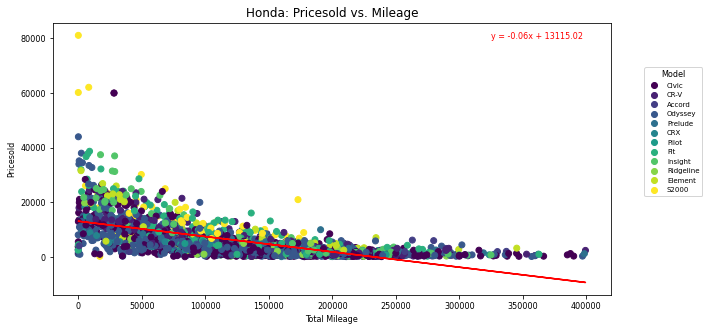

In [36]:
make = "Honda"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (325000,80000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Honda-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.3702532105080784
the correlation between factors plotted in the graph is -0.61


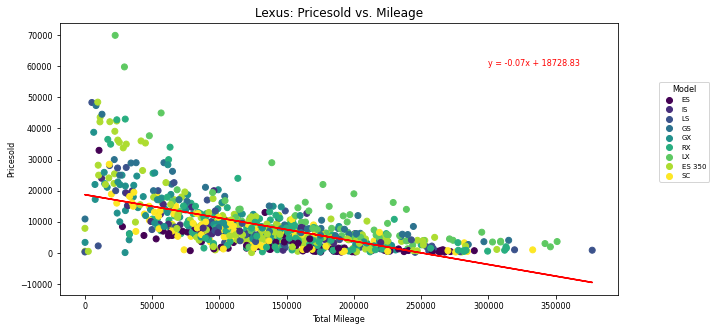

In [37]:
make = "Lexus"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (300000,60000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Lexus-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.40951073979726227
the correlation between factors plotted in the graph is -0.64


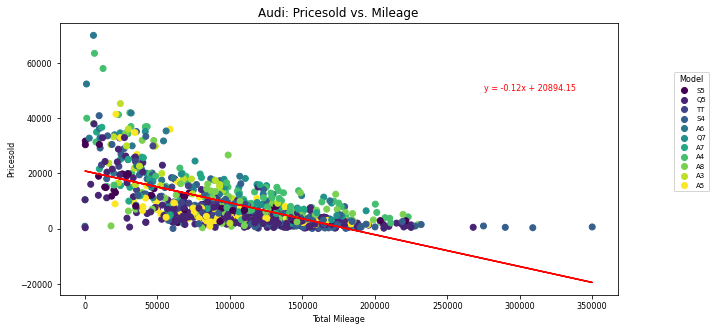

In [38]:
make = "Audi"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (275000,50000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Audi-Price_vs_Mileage.png")

# display graph
plt.show()

the r-squared value is: 0.40427968577909673
the correlation between factors plotted in the graph is -0.64


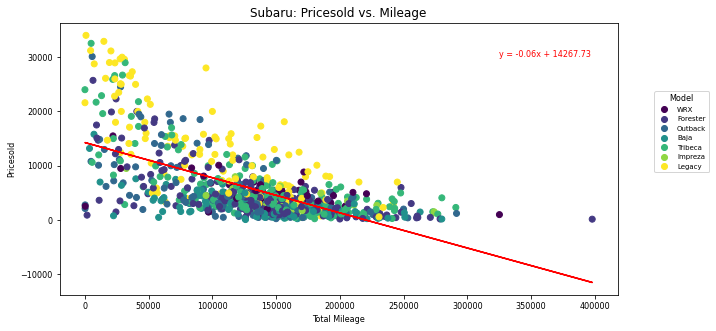

In [39]:
make = "Subaru"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["Mileage"]
y = df_regression["pricesold"]
x_label = "Total Mileage"
y_label = "Pricesold"
label_regression = (325000,30000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. Mileage")

# save image
plt.savefig("Graphs-Analysis/Subaru-Price_vs_Mileage.png")

# display graph
plt.show()

# Analyzing Linear Regression - Price vs. Age (Select Make-Model)

the r-squared value is: 0.3248550239507451
the correlation between factors plotted in the graph is -0.57


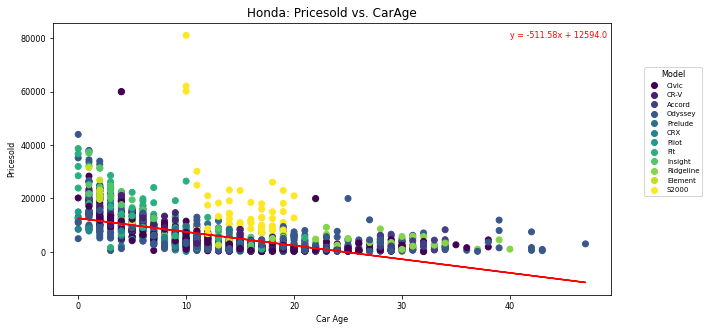

In [40]:
make = "Honda"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (40,80000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Honda-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.455066150409553
the correlation between factors plotted in the graph is -0.67


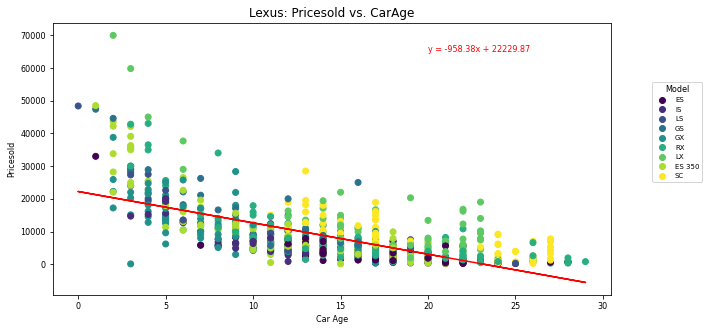

In [41]:
make = "Lexus"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (20,65000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Lexus-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.510401674588309
the correlation between factors plotted in the graph is -0.71


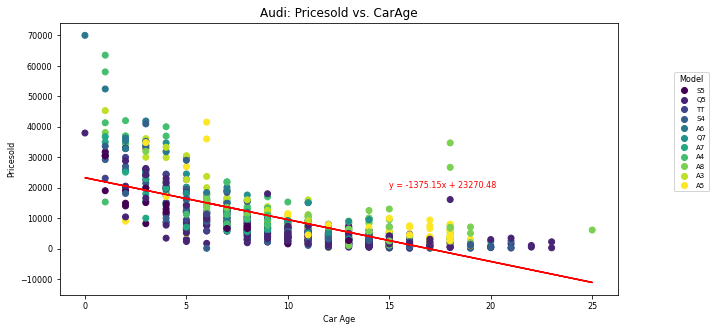

In [42]:
make = "Audi"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (15,20000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Audi-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.33832499668366683
the correlation between factors plotted in the graph is -0.58


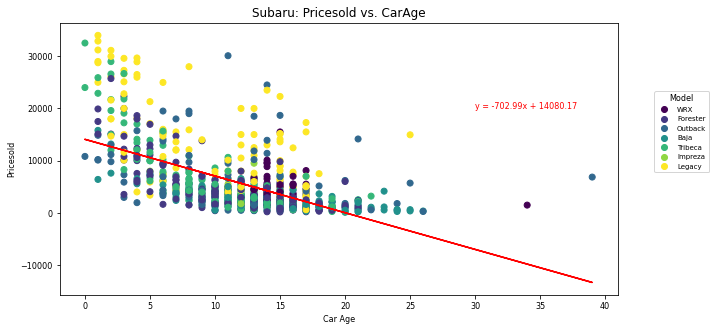

In [43]:
make = "Subaru"

df_regression = pd.DataFrame(df_analysis_final.loc[df_analysis_final["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (30,20000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. CarAge")

# save image
plt.savefig("Graphs-Analysis/Subaru-Price_vs_Age.png")

# display graph
plt.show()

the r-squared value is: 0.22313785107792697
the correlation between factors plotted in the graph is -0.47


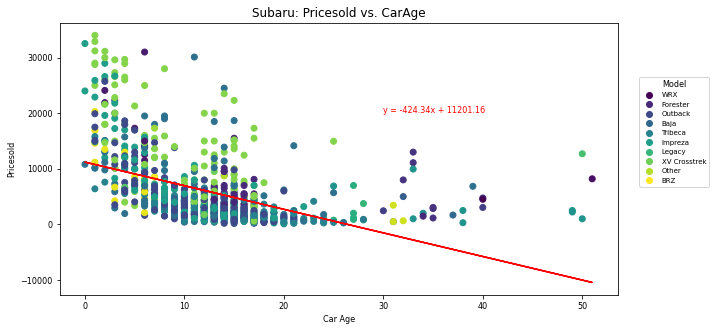

In [44]:
make = "Subaru"

df_regression = pd.DataFrame(df_analysis_filtered.loc[df_analysis_filtered["Make"] == make ,:])

# assign values to arguments to pass into plot_lin_regress paramaters 
x = df_regression["CarAge"]
y = df_regression["pricesold"]
x_label = "Car Age"
y_label = "Pricesold"
label_regression = (30,20000)

# call function
lin_regress_model(x, y, x_label, y_label, label_regression)

# add chart tile
plt.title(f"{make}: Pricesold vs. CarAge")

# save image
# plt.savefig("Graphs-Analysis/Subaru-Price_vs_Age.png")

# display graph
plt.show()